
# Matrix Completion

This notebook tests some existing matrix completion algorithm including:

Noiseless setting:
*   Nuclear norm minimization, see reference paper by Candes and Recht (2008) https://arxiv.org/abs/0805.4471
*   Singular Value Thresholding, see reference paper by Cai et al. (2008)
https://arxiv.org/abs/0810.3286


Reference Repo:
https://github.com/TianyiPeng/matrix-completion

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../cmc')

In [17]:
import numpy as np   
import pandas as pd
import pdb
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [3]:
from utils import *     # contains some useful helper functions 
from models import *    # toy models
from solvers import *   # matrix completion solvers

(CVXPY) Mar 01 07:24:05 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')


# Matrix Completion

In [4]:
# Define experiment parameters
m, n, r = 10,10,2
prob_masked = 0.1
random_state = 1

Sampling from the noiseless random factorization model... 



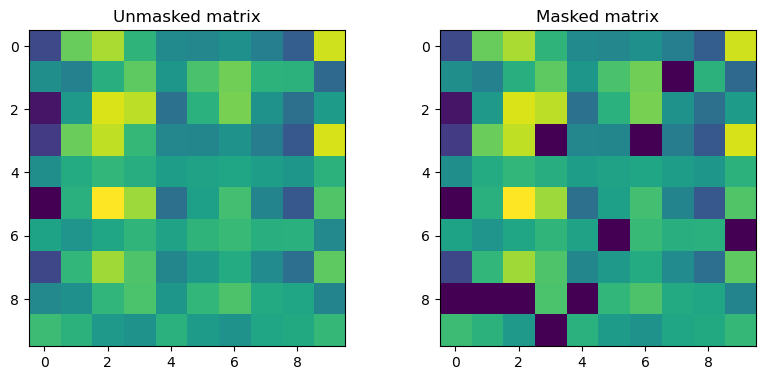



Sampling from the noiseless random orthogonal model... 



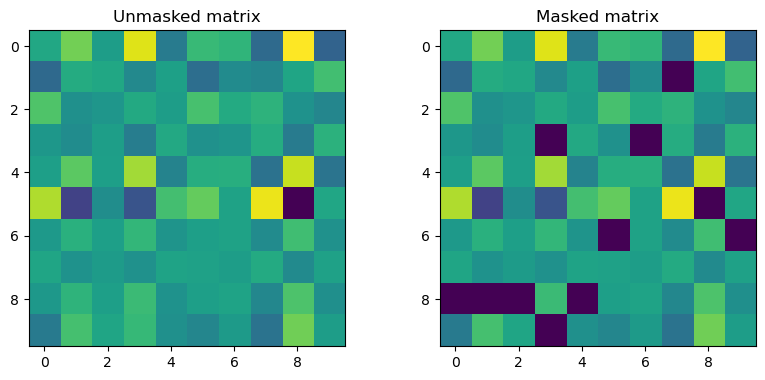

In [5]:
# Generate missing samples
sampler = RandomSampling(m, n)
mask = sampler.sample_observed(prob_masked, random_state=random_state)

print('Sampling from the noiseless random factorization model... \n')
RFM = RandomFactorizationModel(m ,n, r)
_, _ ,M_rfm = RFM.sample_noiseless(random_state)

masked_M_rfm = mask * M_rfm
vmin, vmax = np.min(M_rfm), np.max(M_rfm)
plot_before_after_mask(M_rfm, mask, vmin, vmax)

print('\n'+'='*70+'\n')

print('Sampling from the noiseless random orthogonal model... \n')
ROM = RandomOrthogonalModel(m ,n, r)
_,_,M_rom = ROM.sample_noiseless(random_state)

masked_M_rom = mask * M_rom
vmin, vmax = np.min(M_rom), np.max(M_rom)
plot_before_after_mask(M_rom, mask, vmin, vmax)

In [6]:
nnm_est = nnm_solve(M_rom,mask, verbose=False, random_state=random_state)
nnm_mse = evaluate_mse(M_rom, nnm_est, 1-mask)
print('The MSE of estimation solved by NNM is: {}'.format(nnm_mse))

The MSE of estimation solved by NNM is: 1.3954828100955872e-13


In [7]:
svt_est = svt_solve(M_rom, mask, random_state=random_state)
svt_mse = evaluate_mse(M_rom, svt_est, 1-mask)
print('The MSE of estimation solved by SVT is: {}'.format(svt_mse))

Iteration: 1; Rel error: 1.0000
Iteration: 11; Rel error: 0.0281
Iteration: 21; Rel error: 0.0088
Iteration: 31; Rel error: 0.0030
Iteration: 41; Rel error: 0.0011
Iteration: 51; Rel error: 0.0004
Iteration: 61; Rel error: 0.0001
Stopping criteria met, training terminated.
The MSE of estimation solved by SVT is: 1.5455306392015827e-07


## Conformal prediction

### Conformalized matrix completion with marginal coverage

We first consider the simplest case where we aim to achieve marginal coverage of the missing entries, that is, on average, the true labels of the missing ones are contained in the conformal intervals with high probability. To achive this goal, one need to first construct conformity scores, we will consider:

- Estimation residual: most straightforward conformity scores which simply measures the euclidean distance of the estimation from the true label. 
  **Pros**: Easy to interpret and implement.
  **Cons**: Might not be of optimal efficacy as it treats all the underlying data points as i.i.d, the matrix data structure is not         exploited. 


In [8]:
def get_calib_scores(calib_mask, M, Mhat):
    # use the absolute value of estimation residual as the conformity scores
    calib_idx = np.where(calib_mask == 1)
    return abs(M[calib_idx] - Mhat[calib_idx])

def marginal_PI(calib_mask, test_mask, M, Mhat, alpha):
    """
    Caculate conformal prediction interval with marginal coverage.
    
    Args:
    ------
    calib_mask:   Index set for the calibration data.
    test_mask:    Index set for the test data.
    M:            Matrix to be estimated.
    Mhat:         Estimation of M.
    alpha:        Desired confidence level.
    
    Return:
    -------
    pi:           Prediction interval(s) for the test point(s).  
    """
    
    test_idx = np.where(test_mask == 1)
    calib_scores = get_calib_scores(calib_mask, M, Mhat)
    n_calib = len(calib_scores)
    
    qhat = np.quantile(calib_scores, np.ceil((n_calib+1)*(1-alpha))/n_calib,
                       method='higher')
    
    pi = [[est-qhat, est+qhat] for est in Mhat[test_idx]]
    return pi


def evaluate_PI(pi, x):
    coverage = np.mean([x[i] >= pi[i][0] and x[i] <= pi[i][1] for i in range(len(x))])
    size = np.mean([pi[i][1] - pi[i][0] for i in range(len(x))])
    
    results = pd.DataFrame({})
    results["Coverage"] = [coverage]
    results["Size"] = [size]
    return results

## Experiments

We conduct some experiments with the toy models and compute the conformal prediction intervals for test points with the simplest scores based on estimation residuals.

### Experiment 1: Fixing M, resample train, test, calib sets

In [9]:
def run_single_experiment(M, train_mask, test_mask, calib_mask, alpha, r= None, verbose=True, random_state=0):
    # Sanity check
    assert all(((train_mask + test_mask + calib_mask) <= 1).flatten()),\
           'Found error in sampling process, make sure splitted sets are disjoint'
        
    Mhat = svt_solve(M, train_mask, verbose=verbose, random_state=random_state)
    pi = marginal_PI(calib_mask, test_mask, M, Mhat, alpha)
    calib_mse = evaluate_mse(M, Mhat, calib_mask)
    
    results = evaluate_PI(pi, M[np.where(test_mask == 1)])
    results['Calib_MSE'] = [calib_mse]
    results['Alpha'] = [alpha]
    results['Seed'] = [random_state]
    results['Calib_size'] = [np.sum(calib_mask)]
    results['Train_size'] = [np.sum(train_mask)]
    
    # If the true rank or an estimation is given, approximate the minimal sufficient sample size 
    # for exact coverage.
    if r:
        results['Theory_size'] = [theoretical_bound(M.shape[0], M.shape[1], r, C=1)]
    return results

In [41]:
# Define experiment parameters
m, n, r = 100,100, 8
prob_masked = 0.3
alpha = 0.1
repetition = 100

In [42]:
theoretical_bound(m, n, r, C=1)

11651.0

In [43]:
print('Fixing the ground truth matrix generated from the noiseless random orthogonal model.\n')
ROM = RandomOrthogonalModel(m ,n, r)
U, V, M = ROM.sample_noiseless(random_state=0)
results = pd.DataFrame({})

for i in tqdm(range(repetition)):
    random_state = i
    # Generate missing samples
    sampler = RandomSampling(m, n)
    mask = sampler.sample_observed(prob_masked, random_state=random_state)
    test_mask = np.ones_like(mask) - mask
    train_mask, calib_mask = sampler.sample_train_calib(mask, prob_calib=0.5, 
                                                        random_state = random_state)
    
    res = run_single_experiment(M, train_mask, test_mask, calib_mask, 
                                alpha, r = r, verbose=False, random_state=random_state)
    
    results = pd.concat([results, res])


Fixing the ground truth matrix generated from the noiseless random orthogonal model.



100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [19:49<00:00, 11.90s/it]


Test size is 3000, calibration size is 3500, training size is 3500, theoretical minimum training size is 11651.0


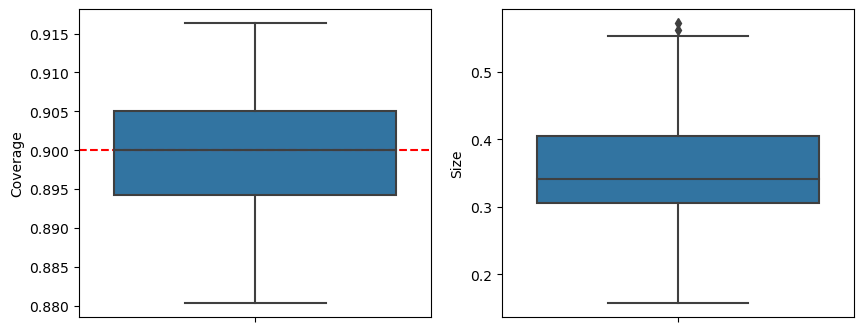

In [44]:
print('Test size is {}, calibration size is {}, training size is {}, theoretical minimum training size is {}'\
      .format(np.sum(test_mask), results['Calib_size'].iloc[0], 
              results['Train_size'].iloc[0], results['Theory_size'].iloc[0]))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
sns.boxplot(y="Coverage", data=results, ax=ax1)
ax1.set(ylabel='Coverage')
ax1.axhline(1-alpha, ls='--', color="red")

sns.boxplot(y="Size", data=results, ax=ax2)
ax2.set(ylabel='Size')
plt.show()

### Experiment 2: Fixing M and test set, resample train, calib sets

In [45]:
# Define experiment parameters
m, n, r = 100,100, 8
prob_masked = 0.3
alpha = 0.1
repetition = 100

In [46]:
print('Fixing the ground truth matrix from ROM and test set.\n')
ROM = RandomOrthogonalModel(m ,n, r)
U, V, M = ROM.sample_noiseless(random_state=0)
results_exp2 = pd.DataFrame({})

sampler = RandomSampling(m, n)
mask = sampler.sample_observed(prob_masked, random_state=0)
test_mask = np.ones_like(mask) - mask

for i in tqdm(range(repetition)):
    random_state = i
    
    # Generate training samples     
    train_mask, calib_mask = sampler.sample_train_calib(mask, prob_calib=0.5, 
                                                        random_state = random_state)
    
    res = run_single_experiment(M, train_mask, test_mask, calib_mask, 
                                alpha, r = r, verbose=False, random_state=random_state)
    
    results_exp2 = pd.concat([results_exp2, res])


Fixing the ground truth matrix from ROM and test set.



100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [17:29<00:00, 10.49s/it]


Test size is 3000, calibration size is 3500, training size is 3500, theoretical minimum training size is 11651.0


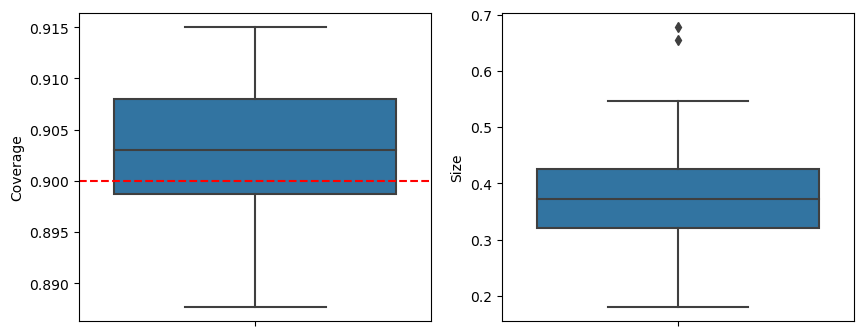

In [47]:
print('Test size is {}, calibration size is {}, training size is {}, theoretical minimum training size is {}'\
      .format(np.sum(test_mask), results['Calib_size'].iloc[0], 
              results_exp2['Train_size'].iloc[0], results_exp2['Theory_size'].iloc[0]))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
sns.boxplot(y="Coverage", data=results_exp2, ax=ax1)
ax1.set(ylabel='Coverage')
ax1.axhline(1-alpha, ls='--', color="red")

sns.boxplot(y="Size", data=results_exp2, ax=ax2)
ax2.set(ylabel='Size')
plt.show()